<a href="https://colab.research.google.com/github/mille-s/Build_KGs_entities/blob/main/LongInput_D2T_25_EvalLLM_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install Aixplain (needed to load pickle files)
from IPython.display import clear_output
import os
! pip install aixplain
clear_output()

! pip install diversity

os.environ["AIXPLAIN_API_KEY"] = '3d039057dcf4e221c7c722debaf56d05d33a565438db0b04b5ead21dac4449de'

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.2 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=314f6bd9fba166f42e968fb137d38e34c12efef1fb5213e86643ac3756bb8e6b
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score
  Attempting uninstall: typer
    Found existing installation: typer 0.17.3
    Uninstalling typer-0.17.3:
      Successfully uninstalled typer-0.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.44.1 requires typer<1.0,>=0.12; sys_platform != "emscripten", but you have typer 0.9.4 which is incompatible.


# Calculate system-level scores
Code taken and adapted from the GEM 2024 code

In [ ]:
#@title Unzip uploaded file
import os
import zipfile
from IPython.display import clear_output

# !unzip /content/GPT_results.zip -d /content
zip_language = 'GA' #@param['EN', 'GA']
zip_model = 'R1_Llama-70B' #@param['GPT-o3', 'Claude', 'Llama-13B', 'R1_Llama-70B', 'R1_Llama-70B_bis']
zip_data = 'regular' #@param['regular', 'iaa']

def unzipEvals(path_dir, zip_path):
  if os.path.exists(path_dir):
    # Remove folder contents
    for filename in os.listdir(path_dir):
      file_path = os.path.join(path_dir, filename)
  else:
    os.makedirs(path_dir)
    print(f'Created folder {path_dir}')
  ! unzip {zip_path} -d {path_dir}
  print(f'Unzipped {zip_path} to {path_dir}')

path_dir = os.path.join(zip_language+'_'+zip_data, zip_model)
zip_path = ''
if zip_data == 'regular':
  if zip_model == 'GPT-o3':
    if zip_language == 'EN':
      zip_path = '/content/EN_GPT_results.zip'
    elif zip_language == 'GA':
      zip_path = '/content/GA_GPT_results.zip'
  elif zip_model == 'Claude':
    if zip_language == 'EN':
      zip_path = '/content/EN_Claude_results.zip'
    elif zip_language == 'GA':
      zip_path = '/content/GA_Claude_results.zip'
  elif zip_model == 'Llama-13B':
    if zip_language == 'EN':
      zip_path = '/content/EN_aiXplainLlama_results.zip'
    elif zip_language == 'GA':
      zip_path = '/content/GA_aiXplainLlama_results.zip'
  elif zip_model == 'R1_Llama-70B':
    if zip_language == 'EN':
      zip_path = '/content/EN_aiXplainDeepseek_results.zip'
    elif zip_language == 'GA':
      zip_path = '/content/GA_aiXplainDeepseek_results.zip'
  elif zip_model == 'R1_Llama-70B_bis':
    if zip_language == 'EN':
      zip_path = '/content/EN_aiXplainDeepseek_results2.zip'
    elif zip_language == 'GA':
      zip_path = ''


unzipEvals(path_dir, zip_path)

# clear_output()

Created folder GA_regular/R1_Llama-70B
Archive:  /content/GA_aiXplainDeepseek_results.zip
   creating: GA_regular/R1_Llama-70B/GA_aiXplainDeepseek_results/
  inflating: GA_regular/R1_Llama-70B/GA_aiXplainDeepseek_results/67976f47e341d313f66bb835_results_ga_D2T-1-FA_0015_10  
  inflating: GA_regular/R1_Llama-70B/GA_aiXplainDeepseek_results/67976f47e341d313f66bb835_results_ga_D2T-1-FA_0015_11  
  inflating: GA_regular/R1_Llama-70B/GA_aiXplainDeepseek_results/67976f47e341d313f66bb835_results_ga_D2T-1-FA_0015_3  
  inflating: GA_regular/R1_Llama-70B/GA_aiXplainDeepseek_results/67976f47e341d313f66bb835_results_ga_D2T-1-FA_0015_5  
  inflating: GA_regular/R1_Llama-70B/GA_aiXplainDeepseek_results/67976f47e341d313f66bb835_results_ga_D2T-1-FA_0015_6  
  inflating: GA_regular/R1_Llama-70B/GA_aiXplainDeepseek_results/67976f47e341d313f66bb835_results_ga_D2T-1-FA_0015_7  
  inflating: GA_regular/R1_Llama-70B/GA_aiXplainDeepseek_results/67976f47e341d313f66bb835_results_ga_D2T-1-FA_0015_8  
  inflati

In [ ]:
#@title Load unzipped files and save in normalised json files
import pickle
import glob
import json
import re
import codecs

def is_valid_pickle(filepath):
  try:
    with open(filepath, 'rb') as f:
      # Check header
      header = f.read(1)
      if header != b'\x80':
          return False
      f.seek(0)
      # Attempt to load safely
      pickle.load(f)
    return True
  except Exception:
    return False


update_params_unzip = True #@param {type:"boolean"}
if update_params_unzip:
  zip_language = 'GA' #@param['EN', 'GA']
  zip_model = 'R1_Llama-70B' #@param['GPT-o3', 'Claude', 'Llama-13B', 'R1_Llama-70B', 'R1_Llama-70B_bis']
  zip_data = 'regular' #@param['regular', 'iaa']

model_scores = [1, 2, 3, 4, 5, 6, 7]
# load_gemini_folder = True #@param {type:"boolean"}
# load_gpt_folder = False #@param {type:"boolean"}
path_dir_unzipped = ''
model_prefix = ''
if zip_model.startswith('Claude_bis'):
  path_dir_unzipped = os.path.join('/content', zip_language+'_'+zip_data, zip_model, zip_language+'_Claude_not_aiXplainLlama_results')
  model_prefix = 'claude-3-7-sonnet-latest'
elif zip_model.startswith('Claude'):
  path_dir_unzipped = os.path.join('/content', zip_language+'_'+zip_data, zip_model, zip_language+'_Claude_results')
  model_prefix = 'claude-3-7-sonnet-latest'
elif zip_model.startswith('GPT'):
  path_dir_unzipped = os.path.join('/content', zip_language+'_'+zip_data, zip_model, zip_language+'_GPT_results')
  model_prefix = 'o3'
elif zip_model.startswith('Llama'):
  path_dir_unzipped = os.path.join('/content', zip_language+'_'+zip_data, zip_model, zip_language+'_aiXplainLlama_results')
  # ERROR HERE? The Llama file actually has that prefix inside
  model_prefix = '6704c91bfdf7d14548c9fedb'
elif zip_model.startswith('R1_Llama-70B_bis'):
  path_dir_unzipped = os.path.join('/content', zip_language+'_'+zip_data, zip_model, zip_language+'_aiXplainDeepseek_results2')
  model_prefix = '67976f47e341d313f66bb835'
elif zip_model.startswith('R1_Llama-70B'):
  path_dir_unzipped = os.path.join('/content', zip_language+'_'+zip_data, zip_model, zip_language+'_aiXplainDeepseek_results')
  model_prefix = '67976f47e341d313f66bb835'

def separateJustification(LLMoutString, criterion):
  """
  The Justifications returned by the models often break the json format, so I extract them
  """
  search_expression = '("'+criterion+'":[^\{]+\{[^\}]*"Justification":)([^\}]+)("Score":[^\}]+\})'
  if re.search(search_expression, LLMoutString):
    justificationRemoved = re.sub(search_expression, '\g<1> "", \g<3>',  LLMoutString)
    justification = re.sub('^.*'+search_expression+'.*$', '\g<2>',  LLMoutString)
  else:
    justificationRemoved = LLMoutString
    justification = ''
  return justificationRemoved, justification

def loadDataPoint(dbfile_x, model):
  eval_missing = None
  wrong_score = None
  dico_key = 'scores_'+str(model)
  formatted_scores = {}
  # load data with pickle
  dp = {}
  if is_valid_pickle(dbfile_x.name):
    dp = pickle.load(dbfile_x)
  else:
    print('The input file is not a pickle file!')
  # print(dp)
  if dico_key in dp:
    print(dp['id'])
    print(dp['triples'])
    print(dp['text'])
    justifications = []
    # pickle.load uses single quotes, whereas json.load expects double quotes
    # Gemini adds a node "query" in the json, unlike OpenAI's models
    LLMout_string = str(dp[dico_key]).replace("'query'", '"query"')
    LLMout_string = LLMout_string.replace("```json", "")
    LLMout_string = LLMout_string.replace("```", "")
    # DeepSeek output is quite different from the rest
    if model == '67976f47e341d313f66bb835':
      LLMout_string = LLMout_string.replace("\\n", '')
      LLMout_string = LLMout_string.replace("\\", '')
      LLMout_string = LLMout_string.replace('"', "'")
      # Can't rely on double bracket closing because sometimes there's only one.
      LLMout_string = re.sub("^.*('output': '\{'No-Omissions': \{[^\}]+\}, 'No-Additions': \{[^\}]+\}, 'Grammaticality': \{[^\}]+\}, 'Fluency': \{[^\}]+\}).*$", "\g<1>", LLMout_string)
    LLMout_string = LLMout_string.replace("'No-Omissions'", '"No-Omissions"')
    # There's a typo in one of the Gemini outputs
    LLMout_string = LLMout_string.replace("'No-Omissons'", '"No-Omissions"')
    LLMout_string = LLMout_string.replace('"No-Omissons"', '"No-Omissions"')
    LLMout_string = LLMout_string.replace("'No-Additions'", '"No-Additions"')
    LLMout_string = LLMout_string.replace("'Grammaticality'", '"Grammaticality"')
    LLMout_string = LLMout_string.replace("'Fluency'", '"Fluency"')
    # Sometimes justifications are followed by single quotes, sometimes by double quotes
    LLMout_string = LLMout_string.replace("'Justification': '", '"Justification": "').replace("'Justification'", '"Justification"')
    LLMout_string = LLMout_string.replace("', 'Score'", '", "Score"').replace("'Score'", '"Score"')
    # print(LLMout_string)
    if LLMout_string == 'None':
      eval_missing = dp['id']
    else:
      # print(LLMout_string)
      # LLMout_string = re.sub('("No-Omissions":[^\{]+\{"Justification":)([^\}]+)("Score":[^\}]+\})', '\g<1> "", \g<3>',  LLMout_string)
      # Claude adds some comments before giving the eval results, this breaks the format
      LLMout_string = re.sub("^[^\{]+", "", LLMout_string)
      LLMout_string, justifNoOm = separateJustification(LLMout_string, 'No-Omissions')
      justifications.append(justifNoOm)
      LLMout_string, justifNoAdd = separateJustification(LLMout_string, 'No-Additions')
      justifications.append(justifNoAdd)
      LLMout_string, justifGram = separateJustification(LLMout_string, 'Grammaticality')
      justifications.append(justifGram)
      LLMout_string, justifFlu = separateJustification(LLMout_string, 'Fluency')
      justifications.append(justifFlu)
      print(justifications)
      LLMout_string = LLMout_string.replace("'1'", '"1"')
      LLMout_string = LLMout_string.replace("'2'", '"2"')
      LLMout_string = LLMout_string.replace("'3'", '"3"')
      LLMout_string = LLMout_string.replace("'4'", '"4"')
      LLMout_string = LLMout_string.replace("'5'", '"5"')
      LLMout_string = LLMout_string.replace("'6'", '"6"')
      LLMout_string = LLMout_string.replace("'7'", '"7"')
      # LLMout_string should finish with 2 braces (cases with only one have been seen)
      if LLMout_string.count('{') > LLMout_string.count('}'):
        while not re.search('\}[\s\r\n]*\}$', LLMout_string):
          LLMout_string = LLMout_string + ' }'
      # print(f'LLMOUT: <<<<<< {LLMout_string}>>>>>>')
      scores_json = json.loads(LLMout_string)
      clean_scores_json = None
      # Gemini adds a node "query" in the json, unlike OpenAI's models
      if 'query' in scores_json:
        clean_scores_json = scores_json['query']
      else:
        clean_scores_json = scores_json

      gram_score = int(clean_scores_json['Grammaticality']['Score'])
      flu_score = int(clean_scores_json['Fluency']['Score'])
      no_om_score = int(clean_scores_json['No-Omissions']['Score'])
      no_ad_score = int(clean_scores_json['No-Additions']['Score'])

      if (gram_score not in model_scores) or (flu_score not in model_scores) or (no_om_score not in model_scores) or (no_ad_score not in model_scores):
        wrong_score = dp['id']

      formatted_scores["eid"] = dp['id']
      formatted_scores["annotator_id"] = str(zip_model)
      formatted_scores["no-omissions"] = no_om_score
      formatted_scores["no-additions"] = no_ad_score
      formatted_scores["grammaticality"] = gram_score
      formatted_scores["fluency"] = flu_score

      print(f"Gram: {gram_score}; Flu: {flu_score}; NoOm: {no_om_score}; NoAd: {no_ad_score}.")
      print('')

  return formatted_scores, eval_missing, wrong_score

print(f'Loaded evaluations found in {path_dir_unzipped}')
print(f'Model ID used inside evaluation files: {model_prefix}')
eval_files = glob.glob(os.path.join(path_dir_unzipped, '*'))
evals_missing = []
wrong_scores = []
all_scores = []
for filepath in eval_files:
  print(filepath)
  dbfile_x = open(filepath, 'rb')
  formatted_scores, eval_missing, wrong_score = loadDataPoint(dbfile_x, model_prefix)
  if eval_missing != None:
    evals_missing.append(eval_missing)
  if wrong_score != None:
    wrong_scores.append(wrong_score)
  dbfile_x.close()
  if len(formatted_scores) > 0:
    all_scores.append(formatted_scores)
print(f'Missing evaluations: {evals_missing}')
print(f'Wrong scores: {wrong_scores}')

# Save all scores into a json file
path_json_out = zip_language+'_'+zip_model+'_scores.json'
with codecs.open(path_json_out, 'w', 'utf-8') as outfile:
  json.dump(all_scores, outfile)

Loaded evaluations found in /content/GA_regular/R1_Llama-70B/GA_aiXplainDeepseek_results
Model ID used inside evaluation files: 67976f47e341d313f66bb835
/content/GA_regular/R1_Llama-70B/GA_aiXplainDeepseek_results/67976f47e341d313f66bb835_results_ga_D2T-1-FA_0148_5
ga_D2T-1-FA_0148_5
"""Peshawar areaMetro 1257000000.0; Peshawar areaTotal 215.0; Peshawar areaCode 091; Peshawar elevation 331.0; Peshawar populationTotal 1970042; Peshawar postalCode 25000; Peshawar utcOffset +5:00; Peshawar country Pakistan; Peshawar governingBody Local_government_in_Pakistan; Peshawar governmentType Mayor–council_government; Peshawar timeZone Pakistan_Standard_Time; Peshawar type List_of_cities_in_Pakistan_by_population; Provincial_Assembly_of_Khyber_Pakhtunkhwa location Peshawar; Provincial_Disaster_Management_Authority_(Khyber_Pakhtunkhwa) location Peshawar; Public_Health_Engineering_Department_(KPK) location Peshawar; Battle_of_Peshawar_(1001) place Peshawar; Battle_of_Peshawar_(1834) place Peshawar; M

In [ ]:
#@title Calculate system_level scores D2T assigned by each LLM for each size

import json
import glob
import os
import math
import pandas as pd

if not os.path.exists('/content/LLM-eval_final_jsons'):
  assert os.path.exists('/content/LLM-eval_final_jsons.zip'), 'You need to upload LLM-eval_final_jsons.zip'
  ! unzip /content/LLM-eval_final_jsons.zip


csv_sys_level_scores = '/content/csv_sysLevel_scores'
if not os.path.exists(csv_sys_level_scores):
  os.makedirs(csv_sys_level_scores)

pd.set_option('display.max_rows', 10)
allowed_scores = [1, 2, 3, 4, 5, 6, 7]
group_by_size = False#@param{type:'boolean'}
# Store here input sizes for making subpopulations of the test set; should contain input_id:size_category
dico_sizes = {'0015': '5' ,'0049': '5' ,'0050': '2' ,'0070': '4' ,'0090': '6' ,'0097': '6' ,'0112': '0' ,'0120': '4' ,'0130': '2' ,'0143': '3' ,'0148': '5' ,'0158': '6' ,'0159': '4' ,'0163': '3' ,'0243': '3' ,'0255': '1' ,'0273': '2' ,'0286': '1' ,'0374': '1' ,'0378': '0' ,'0532': '0'}
# Use this dictionary to map values to other values
score_map = {0:0}

def check_scores(score_list, allowed_scores):
  new_score_list = []
  for score in score_list:
    if score in score_map:
      score = score_map[score]
    assert score in allowed_scores, f'Score out of range: {score}'
    new_score_list.append(score)
  return pd.Series(new_score_list)

DEBUG = False#@param{type:'boolean'}

# Load the files one at a time; there is one file per LLM-language combination (4*3 = 12 files in total)
json_folder = '/content/LLM-eval_final_jsons'
json_files = glob.glob(os.path.join(json_folder, '*.json'))

pd_list = [pd.read_json(json_file) for json_file in sorted(json_files)]

# Create dataframes to store system-level scores
sysLevel_scores_perLLM = pd.DataFrame(columns=['language', 'task', 'system', 'input_size', 'LLM', 'avg_no-omissions', 'avg_no-additions', 'avg_grammaticality', 'avg_fluency'])

system_task_counter = 0
for df in pd_list:
  if DEBUG:
    print(df)
  # LLM and Human files use different IDs (eid VS id)
  # split eid column using underscores and create corresponding columns in the dataframe
  df[['language', 'task', 'id', 'system']] = df['eid'].str.split('_', expand=True)

  # NEW Add a column to df with the size of the input according to dico_sizes
  df['input_size'] = df['id'].map(dico_sizes)

  # Convert 'task' and 'system' columns to string to avoid TypeError during sorting
  df['task'] = df['task'].astype(str)
  df['system'] = df['system'].astype(str)

  print('Getting scores for', df['annotator_id'][0], df['language'][0], '...')

  # Get all possible values for task and system column
  unique_tasks = sorted(df['task'].unique())
  unique_systems = sorted(df['system'].unique())
  unique_input_sizes = sorted(df['input_size'].unique())
  print('', unique_tasks)
  print('', unique_systems)

  # Get the average scores for each system for each task
  for task in unique_tasks:
    if DEBUG:
      print(f'Task: {task}\n===========')
    for system in unique_systems:
      if DEBUG:
        print(f'\nSystem: {system}')
      for size in unique_input_sizes:
        # get scores in each of the 4 score columns
        no_omissions_scores = df.loc[(df['task'] == task) & (df['system'] == system) & (df['input_size'] == size), 'no-omissions']
        no_omissions_scores = check_scores(no_omissions_scores, allowed_scores)
        no_additions_scores = ''
        # LLM and human files have different criterion names (hyphen VS underscore)
        no_additions_scores = df.loc[(df['task'] == task) & (df['system'] == system) & (df['input_size'] == size), 'no-additions']
        no_additions_scores = check_scores(no_additions_scores, allowed_scores)
        grammaticality_scores = df.loc[(df['task'] == task) & (df['system'] == system) & (df['input_size'] == size), 'grammaticality']
        grammaticality_scores = check_scores(grammaticality_scores, allowed_scores)
        fluency_scores = df.loc[(df['task'] == task) & (df['system'] == system) & (df['input_size'] == size), 'fluency']
        fluency_scores = check_scores(fluency_scores, allowed_scores)
        #Get average scores
        average_no_omissions_score = no_omissions_scores.mean()
        average_no_additions_score = no_additions_scores.mean()
        average_grammaticality_score = grammaticality_scores.mean()
        average_fluency_score = fluency_scores.mean()
        if DEBUG:
          if len(no_omissions_scores) > 0:
            print(f'  Average no-omissions score: {average_no_omissions_score}')
            print(f'  Average no-additions score: {average_no_additions_score}')
            print(f'  Average grammaticality score: {average_grammaticality_score}')
            print(f'  Average fluency score: {average_fluency_score}')

        # If there are no numbers to average, "mean" returns a float that prints 'nan'. Filter out these cases.
        if not math.isnan(average_fluency_score):
          # Add a row to sysLevel_scores_perLLM dataframe
          sysLevel_scores_perLLM.loc[system_task_counter] = [df['language'][0], task, system, size, df['annotator_id'][0], average_no_omissions_score, average_no_additions_score, average_grammaticality_score, average_fluency_score]
          system_task_counter += 1

print()
print(sysLevel_scores_perLLM)
# Dump dataframe in a CSV file
sysLevel_scores_perLLM.to_csv(os.path.join(csv_sys_level_scores, 'sysLevel_scores_perLLM.csv'), index=False)

Archive:  /content/LLM-eval_final_jsons.zip
   creating: LLM-eval_final_jsons/
  inflating: LLM-eval_final_jsons/EN_Claude_scores.json  
  inflating: LLM-eval_final_jsons/EN_GPT-o3_scores.json  
  inflating: LLM-eval_final_jsons/GA_Claude_scores.json  
  inflating: LLM-eval_final_jsons/GA_GPT-o3_scores.json  
Getting scores for Claude en ...
 ['D2T-1-FA']
 ['1', '10', '11', '2', '3', '4', '5', '7', '8', '9']
Getting scores for GPT-o3 en ...
 ['D2T-1-FA']
 ['1', '10', '11', '2', '3', '4', '5', '7', '8', '9']
Getting scores for Claude ga ...
 ['D2T-1-FA']
 ['10', '11', '3', '5', '6', '7', '8', '9']
Getting scores for GPT-o3 ga ...
 ['D2T-1-FA']
 ['10', '11', '3', '5', '6', '7', '8', '9']

    language      task system input_size     LLM  avg_no-omissions  \
0         en  D2T-1-FA      1          0  Claude          7.000000   
1         en  D2T-1-FA      1          1  Claude          6.333333   
2         en  D2T-1-FA      1          2  Claude          7.000000   
3         en  D2T-1-FA  

In [ ]:
#@title Get average (across LLMs) system-level scores D2T and create CSV
# There are 4 LLMs which gave evaluations for all datapoints; we need this extra cell for LLMs to get an average LLM score for each system

DEBUG = False#@param{type:'boolean'}

# Create dataframe to store average LLM-assigned system-level scores
avg_sysLevel_scores_LLMs = pd.DataFrame(columns=['language', 'task', 'system', 'input_size', 'LLM', 'avg_no-omissions', 'avg_no-additions', 'avg_grammaticality', 'avg_fluency'])

# Now add a row that averages all LLM scores for each system for each task
unique_languages = sorted(sysLevel_scores_perLLM['language'].unique())
unique_tasks_avg = sorted(sysLevel_scores_perLLM['task'].unique())
unique_systems_avg = sorted(sysLevel_scores_perLLM['system'].unique())
unique_input_sizes_avg = sorted(sysLevel_scores_perLLM['input_size'].unique())

# print(unique_languages)
# print(unique_tasks_avg)
# print(unique_systems_avg)

language_system_task_counter = 0
for language in unique_languages:
  if DEBUG:
    print(f'Language: {language}')
  for task in unique_tasks_avg:
    if DEBUG:
      print(f'Task: {task}')
    for system in unique_systems_avg:
      if DEBUG:
        print(f'System: {system}')
      for size in unique_input_sizes_avg:
        if DEBUG:
          print(f'Size: {size}')
        # Get the average scores for each system for each task
        no_omissions_scores = sysLevel_scores_perLLM.loc[(sysLevel_scores_perLLM['language'] == language) & (sysLevel_scores_perLLM['task'] == task) & (sysLevel_scores_perLLM['system'] == system) & (sysLevel_scores_perLLM['input_size'] == size), 'avg_no-omissions']
        no_additions_scores = sysLevel_scores_perLLM.loc[(sysLevel_scores_perLLM['language'] == language) & (sysLevel_scores_perLLM['task'] == task) & (sysLevel_scores_perLLM['system'] == system) & (sysLevel_scores_perLLM['input_size'] == size), 'avg_no-additions']
        grammaticality_scores = sysLevel_scores_perLLM.loc[(sysLevel_scores_perLLM['language'] == language) & (sysLevel_scores_perLLM['task'] == task) & (sysLevel_scores_perLLM['system'] == system) & (sysLevel_scores_perLLM['input_size'] == size), 'avg_grammaticality']
        fluency_scores = sysLevel_scores_perLLM.loc[(sysLevel_scores_perLLM['language'] == language) & (sysLevel_scores_perLLM['task'] == task) & (sysLevel_scores_perLLM['system'] == system) & (sysLevel_scores_perLLM['input_size'] == size), 'avg_fluency']
        # Get average
        average_no_omissions_score = no_omissions_scores.mean()
        average_no_additions_score = no_additions_scores.mean()
        average_grammaticality_score = grammaticality_scores.mean()
        average_fluency_score = fluency_scores.mean()
        if DEBUG:
          if len(no_omissions_scores) > 0:
            print(f'  Average no-omissions score: {average_no_omissions_score}')
            print(f'  Average no-additions score: {average_no_additions_score}')
            print(f'  Average grammaticality score: {average_grammaticality_score}')
            print(f'  Average fluency score: {average_fluency_score}')

        # If there are no numbers to average, "mean" returns a float that prints 'nan'. Filter out these cases.
        if not math.isnan(average_fluency_score):
          # Add a row to avg_scores dataframe
          avg_sysLevel_scores_LLMs.loc[language_system_task_counter] = [language, task, system, size, 'Average_LLM', average_no_omissions_score, average_no_additions_score, average_grammaticality_score, average_fluency_score]
          language_system_task_counter += 1
          # Dump dataframe in a CSV file
          avg_sysLevel_scores_LLMs.to_csv(os.path.join(csv_sys_level_scores, 'sysLevel_scores_avgLLM.csv'), index=False)

pd.set_option('display.max_rows', None)
print()
print(avg_sysLevel_scores_LLMs)


    language      task system input_size          LLM  avg_no-omissions  \
0         en  D2T-1-FA      1          0  Average_LLM          7.000000   
1         en  D2T-1-FA      1          1  Average_LLM          6.500000   
2         en  D2T-1-FA      1          2  Average_LLM          7.000000   
3         en  D2T-1-FA      1          3  Average_LLM          6.166667   
4         en  D2T-1-FA      1          4  Average_LLM          6.333333   
5         en  D2T-1-FA      1          5  Average_LLM          6.166667   
6         en  D2T-1-FA      1          6  Average_LLM          4.666667   
7         en  D2T-1-FA     10          0  Average_LLM          4.000000   
8         en  D2T-1-FA     10          1  Average_LLM          3.166667   
9         en  D2T-1-FA     10          2  Average_LLM          3.000000   
10        en  D2T-1-FA     10          3  Average_LLM          2.666667   
11        en  D2T-1-FA     10          4  Average_LLM          2.666667   
12        en  D2T-1-FA  

In [ ]:
#@title Zip and download csv folders
from google.colab import files

! zip -r /content/csv_sysLevel_scores.zip /content/csv_sysLevel_scores
files.download('/content/csv_sysLevel_scores.zip')

  adding: content/csv_sysLevel_scores/ (stored 0%)
  adding: content/csv_sysLevel_scores/sysLevel_scores_perLLM.csv (deflated 89%)
  adding: content/csv_sysLevel_scores/sysLevel_scores_avgLLM.csv (deflated 87%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Create plots and LaTeX tables from scores aggregated in "Qualitative evaluation" above.

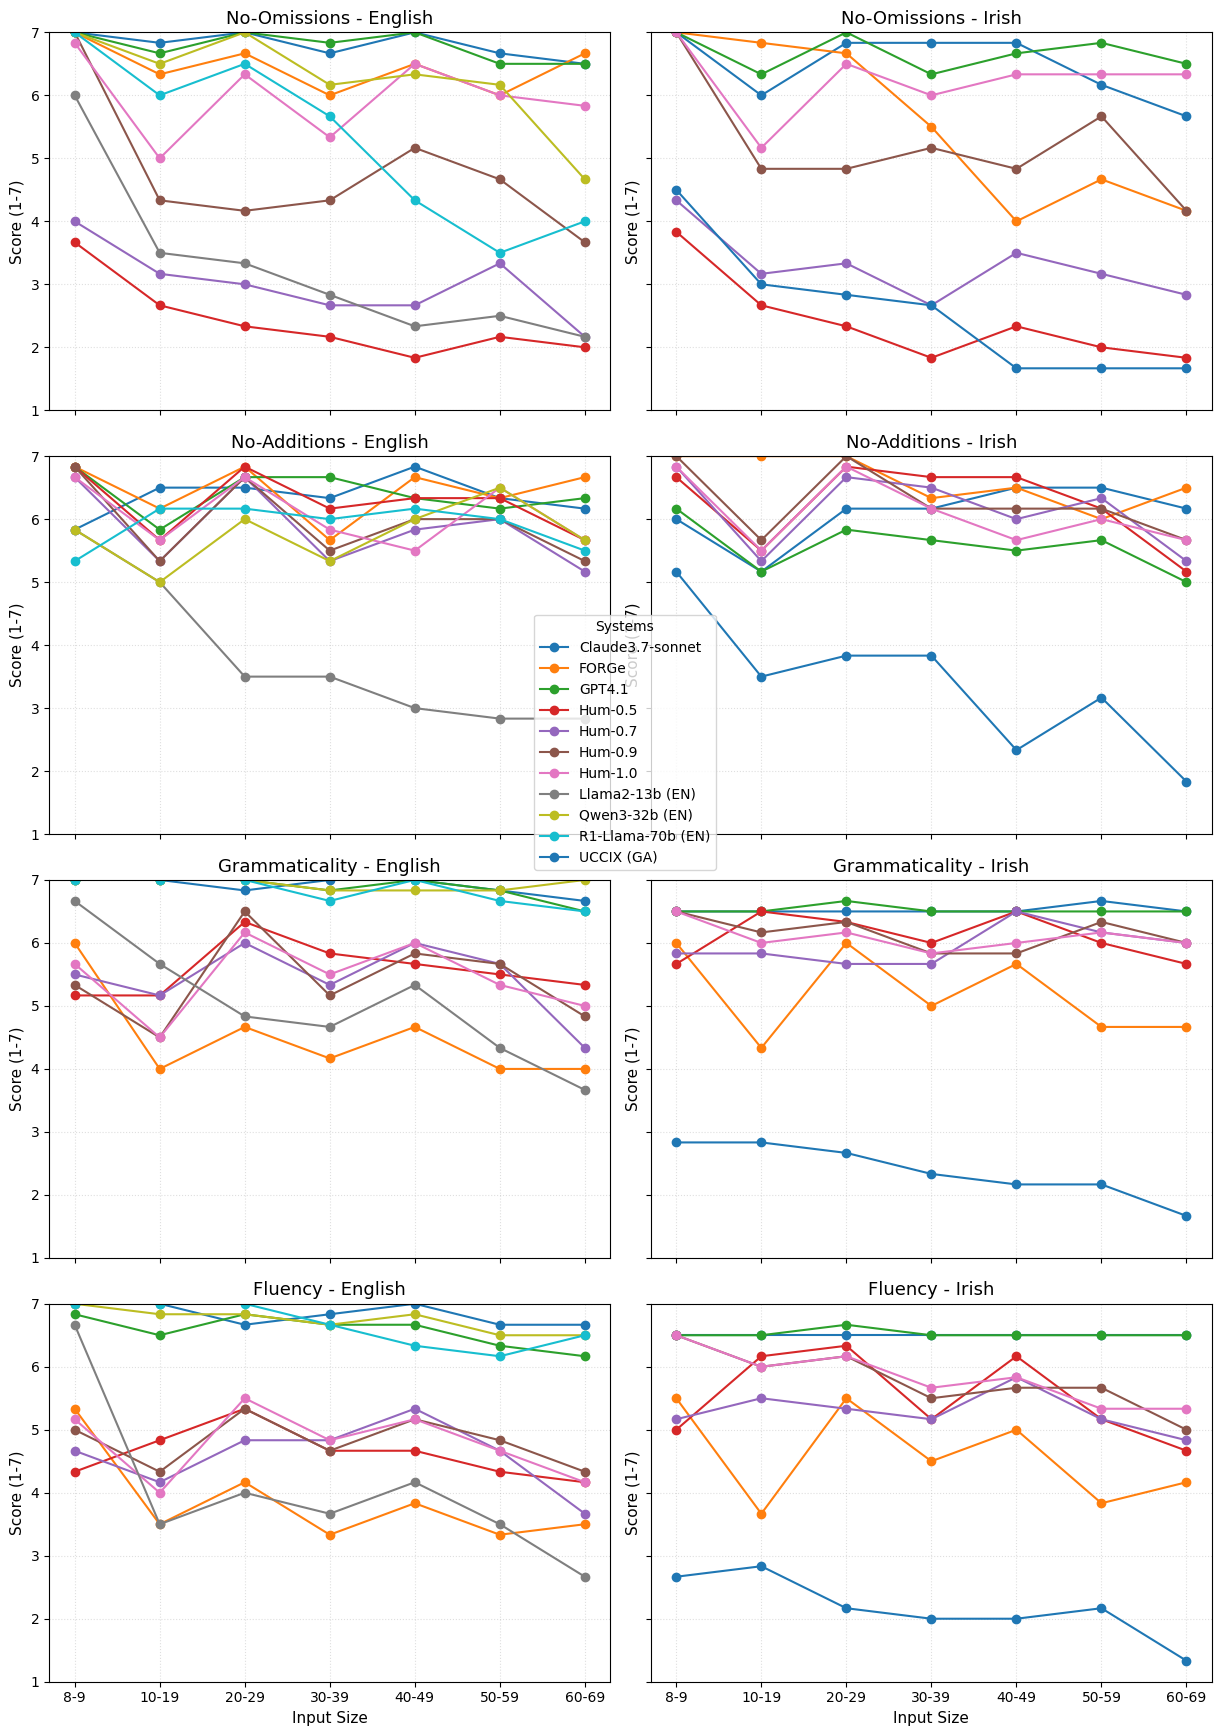

In [ ]:
#@title Functions from GPT

# Re-import essentials
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
if not os.path.exists('/content/figures'):
  os.mkdir('/content/figures')

# Load the CSV again
file_path = "/content/csv_sysLevel_scores/sysLevel_scores_avgLLM.csv"
df = pd.read_csv(file_path)

# Provided system_IDnames_dico
system_IDnames_dico = {
    'en': {'01': 'Qwen3-32b (EN)', '02': 'Llama2-13b (EN)', '03': 'GPT4.1', '04': 'R1-Llama-70b (EN)',
           '05': 'Claude3.7-sonnet', '07': 'FORGe', '08': 'Hum-1.0', '09': 'Hum-0.9',
           '10': 'Hum-0.7', '11': 'Hum-0.5'},
    'ga': {'03': 'GPT4.1', '05': 'Claude3.7-sonnet', '06': 'UCCIX (GA)', '07': 'FORGe',
           '08': 'Hum-1.0', '09': 'Hum-0.9', '10': 'Hum-0.7', '11': 'Hum-0.5'}
}

# Map system IDs to names based on language
def map_system_name(row):
    lang = row['language']
    sys_id = f"{int(row['system']):02d}"
    return system_IDnames_dico.get(lang, {}).get(sys_id, sys_id)

df['system_name'] = df.apply(map_system_name, axis=1)

# Map input_size indices to bins
size_bins = ['8-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69']
df['input_size_bin'] = df['input_size'].map(lambda x: size_bins[int(x)] if int(x) < len(size_bins) else str(x))

# Melt dataframe to long format for seaborn plotting
df_long = df.melt(
    id_vars=['language', 'system_name', 'input_size_bin'],
    value_vars=['avg_no-omissions', 'avg_no-additions', 'avg_grammaticality', 'avg_fluency'],
    var_name='criterion',
    value_name='score'
)

# Prepare consistent color palette across plots for systems
all_systems = sorted(set(df_long['system_name']))
palette = sns.color_palette("tab10", n_colors=len(all_systems))
system_colors = dict(zip(all_systems, palette))

# Plot generation: 4 criteria x 2 languages = 8 plots
criteria_map = {
    'avg_no-omissions': 'No-Omissions',
    'avg_no-additions': 'No-Additions',
    'avg_grammaticality': 'Grammaticality',
    'avg_fluency': 'Fluency'
}

# Create a figure with 4 rows x 2 columns
fig, axes = plt.subplots(4, 2, figsize=(14, 18), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.15)

handles_list = []
labels_list = []
for i, (crit_key, crit_name) in enumerate(criteria_map.items()):
    for j, lang in enumerate(['en', 'ga']):
        ax = axes[i, j]
        subset = df_long[(df_long['criterion'] == crit_key) & (df_long['language'] == lang)]
        for system in sorted(subset['system_name'].unique()):
            sys_data = subset[subset['system_name'] == system]
            ax.plot(
                sys_data['input_size_bin'],
                sys_data['score'],
                label=system,
                marker='o',
                color=system_colors[system]
            )
        ax.set_title(f"{crit_name} - {'English' if lang == 'en' else 'Irish'}", fontsize=13)
        ax.set_ylabel('Score (1-7)', fontsize=11)
        ax.set_ylim(1, 7)
        ax.grid(True, linestyle=':', alpha=0.4)
        if i == 3:
            ax.set_xlabel('Input Size', fontsize=11)

        handles, labels = ax.get_legend_handles_labels()
        for handle in handles:
            if handle not in handles_list:
                handles_list.append(handle)
        for label in labels:
            if label not in labels_list:
                labels_list.append(label)

# Add a legend
# Single legend outside
# Choose colors of labels
# fig.legend(handles_list, labels_list, title='Systems', bbox_to_anchor=(1.02, 0.5), loc='center left')
fig.legend(handles_list, labels_list, title='Systems', bbox_to_anchor=(0.45, 0.48), loc='lower center')

# plt.suptitle('System Performance Across Criteria, Input Sizes, and Languages', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.88, 0.97])
# Save image in a png file
plt.savefig('/content/figures/system_performance_across_criteria_input_sizes_and_languages.png')
plt.show()


In [ ]:
from google.colab import files

# Download image
! zip -r /content/figures.zip /content/figures
files.download('/content/figures.zip')

  adding: content/figures/ (stored 0%)
  adding: content/figures/system_performance_across_criteria_input_sizes_and_languages.png (deflated 6%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Run divesity metrics on output texts (use T4 GPU Runtime)

In [ ]:
#@title Load file with texts of one language for all systems

import json
import codecs
import re

# Open /content/en_longInputD2T_LLMtexts.json
language = 'en' #@param['en', 'ga']
data = json.load(codecs.open(f'/content/{language}_longInputD2T_LLMtexts.json', 'r', 'utf-8'))

unique_sys_ids_dico = {}
for i, datapoint in enumerate(data):
  dp_id = datapoint['id'].rsplit('_', 1)[1]
  # print(dp_id)
  if dp_id not in unique_sys_ids_dico:
    unique_sys_ids_dico[dp_id] = [datapoint['output']]
  else:
    unique_sys_ids_dico[dp_id].append(datapoint['output'])
  # print(datapoint['text'])

# print(unique_sys_ids)
for key in sorted(unique_sys_ids_dico.keys()):
  print(key, unique_sys_ids_dico[key])

1 ['Edward I of England, who began and ended his active years in 1272, was the son of Henry III of England and Eleanor of Provence. He succeeded his father, Henry III, to the throne and was later succeeded by his own son, Edward II of England. Among his notable military engagements, Edward I commanded the English invasion of Scotland in 1296, as well as the Battle of Evesham and the Battle of Falkirk. His personal life included two marriages: first to Eleanor of Castile and later to Margaret of France, Queen of England. Additionally, Eleanor of England, Countess of Bar, was also recorded as his parent in the data. Edward I was associated with several castles, including Bungay Castle, Cheveley Castle, and Woodcroft Castle, which were categorized under his name in historical records.', "Rabat, the capital of Morocco, serves as a central hub for political, cultural, and administrative activities in the country. With a total population of 577,827 residents and a metropolitan population of 

In [ ]:
#@title Diversity metrics functions
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_distances
import numpy as np
from tqdm import tqdm
from nltk.util import ngrams
from typing import List, Optional
from collections import Counter
import torch, gc
from sklearn.metrics.pairwise import pairwise_distances_chunked

from diversity import (
    compression_ratio,
    homogenization_score,
    ngram_diversity_score#,
    # self_repetition_score
)

import math
from collections import Counter

# Can't import chamfer_dist from "diversity", so copied it here
# Also added code to flush memory before returning score
def chamfer_dist(
      data: List[str],
      model: Optional[str] = 'Qwen/Qwen3-Embedding-0.6B',
      verbose: Optional[bool] = True,
      batch_size: Optional[int] = 64
) -> float:
  """
  Calculates the chamfer distance for a set of documents (corpus-level).
  This is the average minimum pairwise distance of a data instance to other instances.
  Args:
      data (List[str]): Strings to score.
      model(str, optional): Model to use for embedding. Defaults to 'Qwen/Qwen3-Embedding-0.6B'.
      verbose(bool, optional): Whether to display progress bar. Defaults to True.
      batch_size(int, optional): Batch size for embedding. Defaults to 64.
  Returns:
      float: Chamfer distance.
  """
  model = SentenceTransformer(model)
  embeddings = model.encode(data, batch_size=batch_size, show_progress_bar=verbose)
  distances = cosine_distances(embeddings)
  min_distances = np.min(distances + np.eye(len(distances)) * 1e9, axis=1)

  # Free up memory
  del embeddings, distances, model
  gc.collect()
  if torch.cuda.is_available():
      torch.cuda.empty_cache()
  return np.mean(min_distances).round(3)

# Functions to avoid OOM errors with very long texts (some have up to 6k words and this produces problems when embedding)
def embed_long_text(text, model, max_length=512, overlap=50):
    """Split long text into chunks, embed, then average-pool."""
    tokens = text.split()
    chunks = []
    for i in range(0, len(tokens), max_length - overlap):
        chunk = " ".join(tokens[i:i + max_length])
        chunks.append(chunk)
    with torch.no_grad():
        chunk_embs = model.encode(chunks, convert_to_numpy=True, show_progress_bar=False)
    return np.mean(chunk_embs, axis=0)  # mean pooling

def chamfer_dist_large(
    data,
    model_name='Qwen/Qwen3-Embedding-0.6B',
    batch_size=64,
    verbose=True
):
    model = SentenceTransformer(model_name)

    # 🔹 Embed each document safely (with progress bar)
    embeddings = []
    for doc in tqdm(data, desc="Encoding documents", disable=not verbose):
        emb = embed_long_text(doc, model)
        embeddings.append(emb)
    embeddings = np.vstack(embeddings)

    # 🔹 Compute pairwise distances in chunks (with progress bar)
    min_dists = []
    for chunk in tqdm(
        pairwise_distances_chunked(embeddings, embeddings, metric="cosine"),
        desc="Computing pairwise distances",
        disable=not verbose
    ):
        np.fill_diagonal(chunk, 1e9)
        min_dists.extend(np.min(chunk, axis=1))

    # 🔹 Cleanup
    del embeddings, model
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    result = float(np.mean(min_dists))
    # print(f"Chamfer distance: {result:.4f}")
    return result


# Using here because the GitHub version ignores the "n" parameter; changed the following "4" by an "n"
# ngram_docs = [list(set([' '.join(ngram) for ngram in ngrams(doc.split(), 4)])) for doc in dataset]
# ngram_docs = [list(set([' '.join(ngram) for ngram in ngrams(doc.split(), n)])) for doc in dataset]
def self_repetition_score(
        dataset: List[str],
        n: int = 4,
        verbose: bool = True
) -> float:
    """
    Calculates a self-repetition score for a dataset based on the
    repetition of ngrams within the corpus.

    Args:
        dataset (List[str]): A list of documents (strings) to analyze.
        n (int): Size of the ngrams to check for repetition. Defaults to 4.
        verbose (bool): enable/disable show progress bar

    Returns:
        float: The self-repetition score, averaged over the dataset.
    """
    total_sum = 0

    # Get all unique ngrams per doc
    ngram_docs = [list(set([' '.join(ngram) for ngram in ngrams(doc.split(), n)])) for doc in dataset]

    # Count occurrences of unique ngrams across whole dataset
    all_ngrams = sum(ngram_docs, [])
    ngram_counts = Counter(all_ngrams)

    for ngram_doc in tqdm(ngram_docs, desc="Calculating self-repetition score", disable=(not verbose)):
        # Find the total occurrence of an n-gram and subtract current doc's n-gram count
        # to get the count of occurrences of an n-gram in other docs
        sum_ni = sum([ngram_counts[ngram] for ngram in ngram_doc]) - len(ngram_doc)

        # add-one to avoid zero error
        total_sum += np.log(sum_ni + 1)
    return total_sum / len(dataset)

###############################################
# Average text length in characters
def avg_text_length(texts):
  avg_length_c = sum(len(text) for text in texts) / len(texts)
  avg_length_c_2f = round(avg_length_c, 2)
  print(f"Average text length: {avg_length_c:.2f} characters")
  # Average text length in words
  avg_length_w = sum(len(text.split()) for text in texts) / len(texts)
  avg_length_w_2f = round(avg_length_w, 2)
  print(f"Average text length: {avg_length_w:.2f} words")
  print('-----------')
  return avg_length_c_2f, avg_length_w_2f

###############################################
# N-gram diversity (distinct-k); number of unique information units (distinct n-grams) divided by the total number of information units (all n-grams) (https://github.com/cshaib/diversity_)
# Calculated using all n-grams until the indicated max size in the parameter
def ngram_diversity_score_1to4(texts):
  # ngd1 = ngram_diversity_score(texts, num_n=1)
  # ngd1_4f = round(ngd1, 4)
  # print(f"1-gram Diversity: {ngd1:.4f}")
  # ngd2 = ngram_diversity_score(texts, num_n=2)
  # ngd2_4f = round(ngd2, 4)
  # print(f"1-2-gram Diversity: {ngd2:.4f}")
  # ngd3 = ngram_diversity_score(texts, num_n=3)
  # ngd3_4f = round(ngd3, 4)
  # print(f"1-2-3-gram Diversity: {ngd3:.4f}")
  ngd4 = ngram_diversity_score(texts, num_n=4)
  ngd4_4f = round(ngd4, 4)
  print(f"n-gram Diversity (1 to 4): {ngd4:.4f}")
  print('-----------')
  return ngd4_4f

###############################################
# Self repetition (https://github.com/cshaib/diversity)
# Calculates a self-repetition score for a dataset based on the repetition of ngrams within the corpus.
def self_repetition_score_1to4(texts):
  srs1 = self_repetition_score(texts, 1)
  srs1_4f = round(srs1, 4)
  print(f"Unigram Self-repetition: {srs1:.4f}")
  srs2 = self_repetition_score(texts, 2)
  srs2_4f = round(srs2, 4)
  print(f"Bigram Self-repetition: {srs2:.4f}")
  srs3 = self_repetition_score(texts, 3)
  srs3_4f = round(srs3, 4)
  print(f"Trigram Self-repetition: {srs3:.4f}")
  srs4 = self_repetition_score(texts, 4)
  srs4_4f = round(srs4, 4)
  print(f"Quadrigram Self-repetition: {srs4:.4f}")
  print('-----------')
  return srs1_4f, srs2_4f, srs3_4f, srs4_4f

###############################################
# Homogenization score: provides a scores representing how homogeneous a set of documents is (https://github.com/cshaib/diversity)
# (used to compare e.g. texts written with and without assistance of LLMs, showing that texts written using LLMs are more homogeneous, i.e. have a higher Homogenization score).
# metric = 'bleu'
def homogenization_score_metric(texts, metric='rougel', use_stemmer = False):
  hs = homogenization_score(texts, measure=metric, use_stemmer=use_stemmer)
  hs_4f = round(hs, 4)
  print(f"Homogenization): {hs:.4f}")
  print('-----------')
  return hs_4f

###############################################
# Compression ratio (https://github.com/cshaib/diversity)
# Compression ratio calculates the ratio of the size of the compressed file to its original size. If the compression ratio is high, it indicates the file was highly compressible and thus had higher redundancy. This would indicate lower diversity in the file contents.
def compression_ratio_func(texts):
  cr = compression_ratio(texts)
  cr_4f = round(cr, 4)
  print(f"Compression ratio: {cr:.4f}")
  print('-----------')
  return cr_4f

###############################################
# Chamfer dist (https://github.com/cshaib/diversity)
# Calculates the chamfer distance for a set of documents (corpus-level). This is the average minimum pairwise distance of a data instance to other instances.
# Qwen/Qwen3-Embedding-0.6B is multilingual and does support Irish
def chamfer_dist_qwen3(texts):
  chd = chamfer_dist(texts, model = 'Qwen/Qwen3-Embedding-0.6B')
  chd_4f = round(chd, 4)
  print(f"Chamfer distance: {chd:.4f}")
  print('-----------')
  return chd_4f

def chamfer_dist_large_qwen3(texts):
  chd = chamfer_dist_large(texts, model_name = 'Qwen/Qwen3-Embedding-0.6B')
  chd_4f = round(chd, 4)
  print(f"Chamfer distance: {chd:.4f}")
  print('-----------')
  return chd_4f

###############################################
# N-gram Entropy (Ent-n) (https://amitness.com/posts/diversity-evals/)
# The intuition behind it is that in an ideal case, all the texts generated from an LLM would be unique and no n-gram would be repeated more than once.
# We can measure this by collecting all the unique bigrams in the text and calculating their count and the relative frequency. This would give us a probability distribution over the bigrams.
# Diversity = Entropy calculated as follows:
# probs = [0.25, 0.25, 0.25, 0.25]
# -sum(p * math.log(p) for p in probs)
def generate_ngrams(words, n: int):
  return [" ".join(words[i : i + n]) for i in range(len(words) - n + 1)]

def ngram_entropy(texts: list[str], n: int = 2) -> float:
  ngrams = []
  for text in texts:
    words = text.split()
    ngrams.extend(generate_ngrams(words, n))

  ngram_counts = Counter(ngrams)
  total_ngrams = sum(ngram_counts.values())

  ngram_frequencies = [count / total_ngrams for ngram, count in ngram_counts.items()]

  entropy = -sum(freq * math.log(freq) for freq in ngram_frequencies)

  return entropy

# print("Unigram entropy:", ngram_entropy(texts, n=1))
# print("Bigram entropy:", ngram_entropy(texts, n=2))
# print("Trigram entropy:", ngram_entropy(texts, n=3))
# print('-----------')


In [ ]:
#@title Run metrics
import pandas as pd

quick_test = False#@param{'type':'boolean'}

# Provided system_IDnames_dico
system_IDnames_dico = {
    'en': {'01': 'Qwen3-32b (EN)', '02': 'Llama2-13b (EN)', '03': 'GPT4.1', '04': 'R1-Llama-70b (EN)',
           '05': 'Claude3.7-sonnet', '07': 'FORGe', '08': 'Hum-1.0', '09': 'Hum-0.9',
           '10': 'Hum-0.7', '11': 'Hum-0.5'},
    'ga': {'03': 'GPT4.1', '05': 'Claude3.7-sonnet', '06': 'UCCIX (GA)', '07': 'FORGe',
           '08': 'Hum-1.0', '09': 'Hum-0.9', '10': 'Hum-0.7', '11': 'Hum-0.5'}
}

if quick_test:
  texts = [
    "The quick brown fox jumps over the lazy dog.",
    "The quick brown fox jumps over the lazy dog again.",
    "Suddenly, the quick brown fox leaps swiftly over the sleeping dog."
  ]
  # Lexical diversity, length
  avg_length_c_2f, avg_length_w_2f = avg_text_length(texts)
  ngd4_4f = ngram_diversity_score_1to4(texts)
  hs_4f = homogenization_score_metric(texts, 'bleu')
  srs1_4f, srs2_4f, srs3_4f, srs4_4f = self_repetition_score_1to4(texts)
  cr_4f = compression_ratio_func(texts)
  # Semantic diversity
  # chd_4f = chamfer_dist_qwen3(texts)
  chd_4f = chamfer_dist_large_qwen3(texts)

else:
  rows = []
  for key in sorted(unique_sys_ids_dico.keys()):
  # key = '2'
    print(f'############################\nCalculating diversity scores for System {key}....')
    texts = unique_sys_ids_dico[key]
    # Lexical diversity, length
    avg_length_c_2f, avg_length_w_2f = avg_text_length(texts)
    ngd4_4f = ngram_diversity_score_1to4(texts)
    # not sure how to interpret homogenization
    hs_4f = homogenization_score_metric(texts, 'rougel', use_stemmer=True)
    srs1_4f, srs2_4f, srs3_4f, srs4_4f = self_repetition_score_1to4(texts)
    cr_4f = compression_ratio_func(texts)
    # Semantic diversity
    chd_4f = chamfer_dist_large_qwen3(texts)
    rows.append({
    "System": system_IDnames_dico[language][key.zfill(2)],
    # "AvgLenC": f"{avg_length_c_2f:.1f}",
    "AvgLenW": f"{avg_length_w_2f:.1f}",
    "NGD-1to4 ($\uparrow$)": f"{ngd4_4f:.2f}",
    "CompRate ($\downarrow$)": f"{cr_4f:.2f}",
    # "Rep1": f"{srs1_4f:.2f}",
    # "Rep2": f"{srs2_4f:.2f}",
    # "Rep3": f"{srs3_4f:.2f}",
    "SelfRep-4 ($\downarrow$)": f"{srs4_4f:.2f}",
    "Homog-RL ($\downarrow$)": f"{hs_4f:.3f}",
    "ChamDist ($\uparrow$)": f"{chd_4f:.2f}"
    })

  df = pd.DataFrame(rows)
  df = df.sort_values(by="System").reset_index(drop=True)
  latex = df.to_latex(index=False, escape=False, column_format="lccccccccccccc")
  print(latex)


############################
Calculating diversity scores for System 1....
Average text length: 1713.10 characters
Average text length: 261.67 words
-----------
n-gram Diversity (1 to 4): 2.9210
-----------
==> Scoring all pairs


100%|██████████| 21/21 [00:10<00:00,  1.92it/s]


Homogenization): 0.1550
-----------


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 23967.45it/s]


Unigram Self-repetition: 6.3315


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 19718.02it/s]


Bigram Self-repetition: 5.4635


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 34047.31it/s]


Trigram Self-repetition: 4.1716


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 17602.00it/s]


Quadrigram Self-repetition: 2.9393
-----------
Compression ratio: 2.6920
-----------


Encoding documents: 100%|██████████| 21/21 [00:03<00:00,  6.39it/s]
Computing pairwise distances: 1it [00:00, 467.64it/s]


Chamfer distance: 0.4876
-----------
############################
Calculating diversity scores for System 10....
Average text length: 824.86 characters
Average text length: 133.29 words
-----------
n-gram Diversity (1 to 4): 2.8640
-----------
==> Scoring all pairs


100%|██████████| 21/21 [00:03<00:00,  6.52it/s]


Homogenization): 0.1560
-----------


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 37932.98it/s]


Unigram Self-repetition: 5.5749


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 30456.56it/s]


Bigram Self-repetition: 4.8126


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 31101.83it/s]


Trigram Self-repetition: 3.7601


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 5677.84it/s]


Quadrigram Self-repetition: 2.8728
-----------
Compression ratio: 2.5840
-----------


Encoding documents: 100%|██████████| 21/21 [00:01<00:00, 11.09it/s]
Computing pairwise distances: 1it [00:00, 672.92it/s]


Chamfer distance: 0.4921
-----------
############################
Calculating diversity scores for System 11....
Average text length: 568.76 characters
Average text length: 93.76 words
-----------
n-gram Diversity (1 to 4): 2.8730
-----------
==> Scoring all pairs


100%|██████████| 21/21 [00:01<00:00, 12.67it/s]


Homogenization): 0.1630
-----------


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 18978.75it/s]


Unigram Self-repetition: 5.3653


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 40348.32it/s]


Bigram Self-repetition: 4.5216


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 37625.11it/s]


Trigram Self-repetition: 3.5929


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 45449.11it/s]


Quadrigram Self-repetition: 2.7612
-----------
Compression ratio: 2.5270
-----------


Encoding documents: 100%|██████████| 21/21 [00:01<00:00, 12.99it/s]
Computing pairwise distances: 1it [00:00, 598.16it/s]


Chamfer distance: 0.4946
-----------
############################
Calculating diversity scores for System 2....
Average text length: 1801.71 characters
Average text length: 305.48 words
-----------
n-gram Diversity (1 to 4): 1.5880
-----------
==> Scoring all pairs


100%|██████████| 21/21 [00:12<00:00,  1.63it/s]


Homogenization): 0.1270
-----------


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 36187.50it/s]


Unigram Self-repetition: 5.5169


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 27252.59it/s]


Bigram Self-repetition: 4.8347


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 25845.18it/s]


Trigram Self-repetition: 3.5980


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 25928.87it/s]


Quadrigram Self-repetition: 2.2783
-----------
Compression ratio: 4.3650
-----------


Encoding documents: 100%|██████████| 21/21 [00:04<00:00,  4.63it/s]
Computing pairwise distances: 1it [00:00, 510.69it/s]


Chamfer distance: 0.4860
-----------
############################
Calculating diversity scores for System 3....
Average text length: 1752.38 characters
Average text length: 279.29 words
-----------
n-gram Diversity (1 to 4): 2.6980
-----------
==> Scoring all pairs


100%|██████████| 21/21 [00:11<00:00,  1.75it/s]


Homogenization): 0.1620
-----------


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 24237.86it/s]


Unigram Self-repetition: 6.3850


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 15273.17it/s]


Bigram Self-repetition: 5.7668


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 11180.55it/s]


Trigram Self-repetition: 4.7509


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 11933.39it/s]


Quadrigram Self-repetition: 3.7369
-----------
Compression ratio: 2.8310
-----------


Encoding documents: 100%|██████████| 21/21 [00:04<00:00,  4.93it/s]
Computing pairwise distances: 1it [00:00, 604.19it/s]


Chamfer distance: 0.5033
-----------
############################
Calculating diversity scores for System 4....
Average text length: 1506.24 characters
Average text length: 235.33 words
-----------
n-gram Diversity (1 to 4): 2.8670
-----------
==> Scoring all pairs


100%|██████████| 21/21 [00:08<00:00,  2.40it/s]


Homogenization): 0.1630
-----------


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 23715.77it/s]


Unigram Self-repetition: 6.2549


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 21441.18it/s]


Bigram Self-repetition: 5.4783


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 22327.09it/s]


Trigram Self-repetition: 4.2361


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 16146.72it/s]


Quadrigram Self-repetition: 3.1107
-----------
Compression ratio: 2.6870
-----------


Encoding documents: 100%|██████████| 21/21 [00:03<00:00,  6.99it/s]
Computing pairwise distances: 1it [00:00, 791.08it/s]


Chamfer distance: 0.4788
-----------
############################
Calculating diversity scores for System 5....
Average text length: 2112.71 characters
Average text length: 315.14 words
-----------
n-gram Diversity (1 to 4): 2.8540
-----------
==> Scoring all pairs


100%|██████████| 21/21 [00:14<00:00,  1.41it/s]


Homogenization): 0.1520
-----------


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 20886.98it/s]


Unigram Self-repetition: 6.6366


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 16700.87it/s]


Bigram Self-repetition: 5.7254


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 17099.67it/s]


Trigram Self-repetition: 4.5831


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 17307.99it/s]


Quadrigram Self-repetition: 3.6778
-----------
Compression ratio: 2.8360
-----------


Encoding documents: 100%|██████████| 21/21 [00:04<00:00,  5.15it/s]
Computing pairwise distances: 1it [00:00, 462.74it/s]


Chamfer distance: 0.5044
-----------
############################
Calculating diversity scores for System 7....
Average text length: 1141.57 characters
Average text length: 184.86 words
-----------
n-gram Diversity (1 to 4): 2.8690
-----------
==> Scoring all pairs


100%|██████████| 21/21 [00:06<00:00,  3.44it/s]


Homogenization): 0.1520
-----------


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 23831.27it/s]


Unigram Self-repetition: 5.8192


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 21609.52it/s]


Bigram Self-repetition: 5.2914


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 26261.30it/s]


Trigram Self-repetition: 4.1593


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 27820.72it/s]


Quadrigram Self-repetition: 3.1290
-----------
Compression ratio: 2.5940
-----------


Encoding documents: 100%|██████████| 21/21 [00:02<00:00,  8.32it/s]
Computing pairwise distances: 1it [00:00, 584.49it/s]


Chamfer distance: 0.4985
-----------
############################
Calculating diversity scores for System 8....
Average text length: 1190.71 characters
Average text length: 191.29 words
-----------
n-gram Diversity (1 to 4): 2.8720
-----------
==> Scoring all pairs


100%|██████████| 21/21 [00:06<00:00,  3.07it/s]


Homogenization): 0.1570
-----------


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 30435.52it/s]


Unigram Self-repetition: 5.8999


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 22480.96it/s]


Bigram Self-repetition: 5.2550


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 26051.58it/s]


Trigram Self-repetition: 4.1095


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 24412.52it/s]


Quadrigram Self-repetition: 3.1170
-----------
Compression ratio: 2.6030
-----------


Encoding documents: 100%|██████████| 21/21 [00:02<00:00,  7.79it/s]
Computing pairwise distances: 1it [00:00, 693.50it/s]


Chamfer distance: 0.4844
-----------
############################
Calculating diversity scores for System 9....
Average text length: 1085.52 characters
Average text length: 174.76 words
-----------
n-gram Diversity (1 to 4): 2.8670
-----------
==> Scoring all pairs


100%|██████████| 21/21 [00:04<00:00,  4.57it/s]


Homogenization): 0.1560
-----------


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 58177.27it/s]


Unigram Self-repetition: 5.8303


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 30851.27it/s]


Bigram Self-repetition: 5.1743


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 26418.83it/s]


Trigram Self-repetition: 4.0271


Calculating self-repetition score: 100%|██████████| 21/21 [00:00<00:00, 26450.57it/s]


Quadrigram Self-repetition: 3.0849
-----------
Compression ratio: 2.5990
-----------


Encoding documents: 100%|██████████| 21/21 [00:02<00:00,  8.48it/s]
Computing pairwise distances: 1it [00:00, 771.86it/s]


Chamfer distance: 0.4842
-----------
\begin{tabular}{lccccccccccccc}
\toprule
System & AvgLenW & NGD-4 & SelfRep-4 & Homog-RL & CompRate & Chamfer \\
\midrule
Claude3.7-sonnet & 315.1 & 2.85 & 3.68 & 0.152 & 2.84 & 0.50 \\
FORGe & 184.9 & 2.87 & 3.13 & 0.152 & 2.59 & 0.50 \\
GPT4.1 & 279.3 & 2.70 & 3.74 & 0.162 & 2.83 & 0.50 \\
Hum-0.5 & 93.8 & 2.87 & 2.76 & 0.163 & 2.53 & 0.49 \\
Hum-0.7 & 133.3 & 2.86 & 2.87 & 0.156 & 2.58 & 0.49 \\
Hum-0.9 & 174.8 & 2.87 & 3.08 & 0.156 & 2.60 & 0.48 \\
Hum-1.0 & 191.3 & 2.87 & 3.12 & 0.157 & 2.60 & 0.48 \\
Llama2-13b (EN) & 305.5 & 1.59 & 2.28 & 0.127 & 4.37 & 0.49 \\
Qwen3-32b (EN) & 261.7 & 2.92 & 2.94 & 0.155 & 2.69 & 0.49 \\
R1-Llama-70b (EN) & 235.3 & 2.87 & 3.11 & 0.163 & 2.69 & 0.48 \\
\bottomrule
\end{tabular}

